In [1]:
import numpy as np
import os
import pickle

# os.listdir('FeatruesTrain')



In [3]:
train_dir = 'FeatruesTrain'
# test_dir = 'FeatruesTest'


DATA = []
d = train_dir
for i in os.listdir(d):
    with open(os.path.join(d,i), 'rb') as f:
        DATA.append(pickle.load(f))
    

FileNotFoundError: ignored

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


labels = {'angry': 0, 
          'calm': 1, 
          'disgust': 2, 
          'fearful': 3, 
          'happy': 4 , 
          'neutral': 5, 
          'sad': 6,
          'surprised': 7}


x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']
X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in x_keys]) for i in DATA]] # full model
Y = np.c_[[labels[i['emotion']] for i in DATA]].flatten()

# X = np.c_[[i['tonnetz'].flatten() for i in DATA]]
# Y = np.c_[[np.eye(Y.max()+1)[i] for i in Y.flatten()]] # one hot


/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [ ]:
# backwards selection 
import time
from sklearn.model_selection import cross_val_score
import warnings
CVS = []
LR = LogisticRegression(C=0.001)
x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']
X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in x_keys]) for i in DATA]] # full model

t1 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    CVS.append(cross_val_score(LR, X, Y, cv=5, n_jobs=5))
print(f'Full model: {time.time()-t1:.4f}')
        
rm_ids = []
for i in range(4):
    t1 = time.time()
    
    step_score = []
    for rm_key in x_keys:
        X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in np.setdiff1d(x_keys, rm_key)]) for i in DATA]]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            step_score.append(cross_val_score(LR, X, Y, cv=5, n_jobs=5))

    scores = [i.mean() for i in step_score]
    rm_id = np.argmax(scores)
    CVS.append(step_score[rm_id])
    x_keys = np.setdiff1d(x_keys, x_keys[rm_id])
    rm_ids.append(rm_id)
    print(f'Step {i+1}: {time.time()-t1:.4f}')



Full model: 85.2124
Step 1: 365.8357
Step 2: 76.4848
Step 3: 44.1032
Step 4: 16.7445


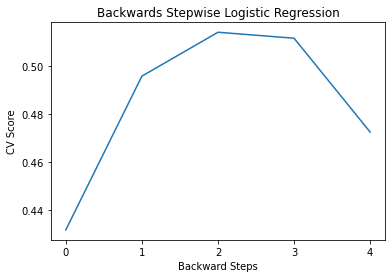

In [ ]:
import matplotlib.pyplot as plt
cv_scores = [i.mean() for i in CVS]


plt.plot(np.arange(0,5), cv_scores)
plt.ylabel('CV Score')
plt.xlabel('Backward Steps')
plt.xticks(np.arange(0,5))
plt.title('Backwards Stepwise Logistic Regression')
plt.show()

In [ ]:
x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']

for i in np.array(rm_ids)[:np.argmax(cv_scores)]:
    x_keys = np.delete(x_keys, i)
    
X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in x_keys]) for i in DATA]]

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000]}

LR = LogisticRegression()
GS = GridSearchCV(LR, parameters, cv=5, n_jobs=10)
GS.fit(X,Y)

/home/yenho/miniconda3/envs/harmonize/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=10,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000,
                               10000]})

In [ ]:
best_LR = GS.best_estimator_

print(GS.best_params_)
print(GS.best_score_)

{'C': 0.01}
0.5266666666666666


In [ ]:
from sklearn.metrics import confusion_matrix
pred = LR.predict(x_test)
cm = confusion_matrix(y_test, pred)

print(cm)
print(cm/cm.sum(1).reshape(-1,1))

[[22  0  2  2  3  0  3  0]
 [ 1 17  3  1  2  4  3  1]
 [ 6  4 11  2  0  1  5  3]
 [ 4  4  1 15  3  0  2  3]
 [ 5  2  4  1  6  0  6  8]
 [ 1  1  2  0  0  8  2  2]
 [ 2  3  7  4  2  1  6  7]
 [ 1  1  4  4  5  1  5 11]]
[[0.6875  0.      0.0625  0.0625  0.09375 0.      0.09375 0.     ]
 [0.03125 0.53125 0.09375 0.03125 0.0625  0.125   0.09375 0.03125]
 [0.1875  0.125   0.34375 0.0625  0.      0.03125 0.15625 0.09375]
 [0.125   0.125   0.03125 0.46875 0.09375 0.      0.0625  0.09375]
 [0.15625 0.0625  0.125   0.03125 0.1875  0.      0.1875  0.25   ]
 [0.0625  0.0625  0.125   0.      0.      0.5     0.125   0.125  ]
 [0.0625  0.09375 0.21875 0.125   0.0625  0.03125 0.1875  0.21875]
 [0.03125 0.03125 0.125   0.125   0.15625 0.03125 0.15625 0.34375]]


In [ ]:
import joblib


from joblib import Parallel, delayed
from sklearn.svm import LinearSVC
import numpy as np

def train_model(X, y, seed):
    model = LinearSVC(random_state=seed)
    return model.fit(X, y)

# X = np.array([[1,2,3],[4,5,6]])
# y = np.array([0, 1])
X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in np.setdiff1d(x_keys, rm_key)]) for i in DATA]]




# Xs = 
result = Parallel(n_jobs=4)(delayed(train_model)(X, y, seed) for seed in range(10))

# result is a list of 10 models trained using different seeds

In [ ]:
CVS


[array([0.40833333, 0.49166667, 0.43333333, 0.4125    , 0.4125    ]),
 0.4958333333333334,
 0.5141666666666668,
 0.5116666666666666,
 0.4725]

### NN

In [ ]:
import torch


True

In [ ]:
x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']
# X = np.c_[[np.concatenate([(i[j]/i[j].std()).flatten() for j in x_keys]) for i in DATA]] # full model
# X = np.c_[[np.concatenate([((i[j]-i[j].mean())/i[j].std()).flatten() for j in x_keys]) for i in DATA]] # full model




In [ ]:
from torch import nn

class NN(nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
#             nn.Linear(141860, 4096),
#             nn.Linear(31980, 2048),
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(2048, 8),
            
            
#             nn.Dropout(0.5),

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        sm = nn.functional.softmax(logits+10, dim=1) # numerically stable softmax
        return sm
    
from torch.utils.data import Dataset, DataLoader

class AudioData(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.Y_oh  = np.c_[[np.eye(self.Y.max()+1)[i] for i in self.Y.flatten()]]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):        
        return self.X[idx], self.Y_oh[idx]

In [ ]:
from sklearn.model_selection import train_test_split


x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']

for i in np.array(rm_ids)[:np.argmax(cv_scores)]:
    x_keys = np.delete(x_keys, i)
    
X = np.c_[[np.concatenate([((i[j]-i[j].mean())/i[j].std()).flatten() for j in x_keys]) for i in DATA]]

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, stratify=Y)


In [ ]:
import torch.optim as optim

net = NN(x_train.shape[1])
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)




NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=31980, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=2048, out_features=8, bias=True)
  )
)


In [ ]:
AD_train = AudioData(x_train, y_train)
AD_val = AudioData(x_val, y_val)

trainloader = DataLoader(AD_train, batch_size=512, shuffle=True)
valloader = DataLoader(AD_val, batch_size=512, shuffle=True)

In [ ]:
n_epochs = 25

history = {'train_loss': [],
           'train_acc':[],
          'val_loss': [],
          'val_acc':[]}

for epoch in range(n_epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*len(inputs)        
        predicted = outputs.argmax(1)
        
        total += labels.size(0)
        correct += (predicted == labels.argmax(1)).sum().item()
    print(total)
    train_loss = train_loss/total
    train_acc = correct/total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
        
    # compute validation
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            
            outputs = net(images.float())
            
            labels = labels.argmax(1)
            predicted = outputs.argmax(1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()*len(inputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct/total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    

    print(f'Epoch: {epoch}\ttrain loss: {train_loss:.4f}\ttrain acc: {train_acc:.4f}\tval loss: {val_loss:.4f}\tval acc: {val_acc:.4f}')

        # print statistics
        
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
#     break
print('Finished Training')

960
Epoch: 0	train loss: 1.2763	train acc: 0.9990	val loss: 3.1589	val acc: 0.6208
960
Epoch: 1	train loss: 1.2760	train acc: 0.9990	val loss: 3.1500	val acc: 0.6167
960
Epoch: 2	train loss: 1.2759	train acc: 0.9990	val loss: 3.1430	val acc: 0.6167
960
Epoch: 3	train loss: 1.2757	train acc: 0.9990	val loss: 3.1377	val acc: 0.6208
960
Epoch: 4	train loss: 1.2756	train acc: 0.9990	val loss: 3.1335	val acc: 0.6250
960
Epoch: 5	train loss: 1.2755	train acc: 0.9990	val loss: 3.1305	val acc: 0.6292
960
Epoch: 6	train loss: 1.2754	train acc: 0.9990	val loss: 3.1280	val acc: 0.6292
960
Epoch: 7	train loss: 1.2750	train acc: 1.0000	val loss: 3.1262	val acc: 0.6292
960
Epoch: 8	train loss: 1.2747	train acc: 1.0000	val loss: 3.1251	val acc: 0.6292
960
Epoch: 9	train loss: 1.2744	train acc: 1.0000	val loss: 3.1250	val acc: 0.6292
960
Epoch: 10	train loss: 1.2744	train acc: 1.0000	val loss: 3.1252	val acc: 0.6375
960
Epoch: 11	train loss: 1.2743	train acc: 1.0000	val loss: 3.1246	val acc: 0.6458
96

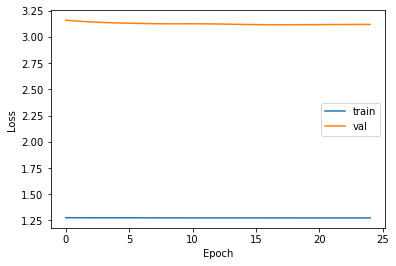

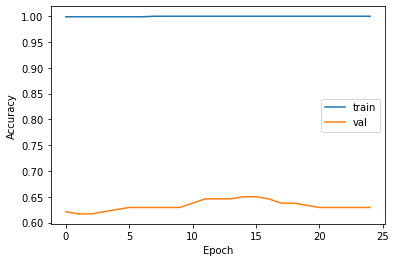

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

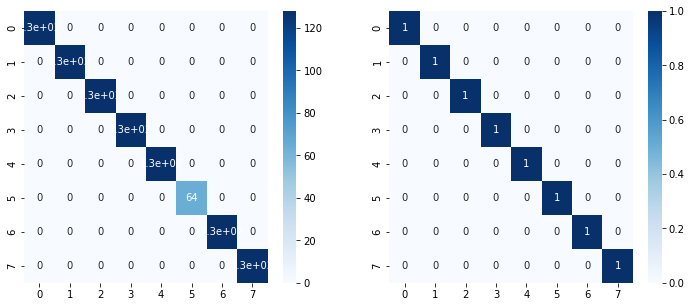

Train accuracy: 1.0


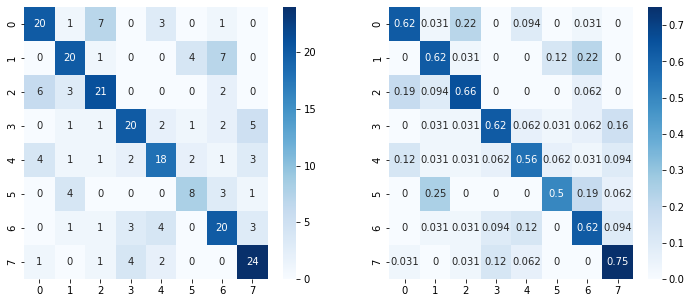

Val accuracy: 0.6291666666666667


In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            
            outputs = mdl(inputs.float())
            labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted)
            y_true.append(labels)
            

            total += len(inputs)
            correct += (labels == predicted).sum().item()

    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_cm = get_confusion_matrix(net,trainloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

val_cm = get_confusion_matrix(net,valloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)


plot_cm(train_cm)
print(f'Train accuracy: {train_acc}')

plot_cm(val_cm)
print(f'Val accuracy: {val_acc}')


## CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(
            
            nn.Conv2d(1, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            
            
            nn.Linear(118080, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 8),
            
            

        )

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
    
#         x = self.flatten(x)
        logits = self.convnet(x)
        sm = nn.functional.softmax(logits+10, dim=1) # numerically stable softmax
        return sm




In [ ]:
x_keys = ['mfccCoeffs', 'chromaCoeffs', 'melspectCoeffs', 'contrastCoeffs', 'tonnetz']

for i in np.array(rm_ids)[:np.argmax(cv_scores)]:
    x_keys = np.delete(x_keys, i)
    
X = np.c_[[np.concatenate([((i[j]-i[j].mean())/i[j].std()) for j in x_keys]) for i in DATA]]

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, stratify=Y)


In [ ]:
AD_train = AudioData(x_train, y_train)
AD_val = AudioData(x_val, y_val)

trainloader = DataLoader(AD_train, batch_size=512, shuffle=True)
valloader = DataLoader(AD_val, batch_size=512, shuffle=True)

In [ ]:
CNN = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr=1e-4, weight_decay=1e-5)


In [ ]:
n_epochs = 25

history = {'train_loss': [],
           'train_acc':[],
          'val_loss': [],
          'val_acc':[]}

for epoch in range(n_epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs = torch.unsqueeze(inputs, 1)

        # forward + backward + optimize
        outputs = CNN(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         train_loss += loss.item()        
#         predicted = outputs.argmax(1)
        
#         total += labels.size(0)
#         correct += (predicted == labels.argmax(1)).sum().item()
        
        
        train_loss += loss.item()*len(inputs)        
        predicted = outputs.argmax(1)
        
        total += labels.size(0)
        correct += (predicted == labels.argmax(1)).sum().item()
        
    train_loss = train_loss/total
    train_acc = correct/total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
        
    # compute validation
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            labels = labels.argmax(1)
            inputs = torch.unsqueeze(inputs, 1)
            outputs = CNN(inputs.float())
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct/total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    

    print(f'Epoch: {epoch}\ttrain loss: {train_loss:.4f}\ttrain acc: {train_acc:.4f}\tval loss: {val_loss:.4f}\tval acc: {val_acc:.4f}')



print('Finished Training')

Epoch: 0	train loss: 2.0082	train acc: 0.1969	val loss: 1.9050	val acc: 0.3917
Epoch: 1	train loss: 1.8075	train acc: 0.5042	val loss: 1.8707	val acc: 0.4125
Epoch: 2	train loss: 1.7231	train acc: 0.6156	val loss: 1.8463	val acc: 0.4542
Epoch: 3	train loss: 1.6594	train acc: 0.6927	val loss: 1.8283	val acc: 0.4625
Epoch: 4	train loss: 1.5969	train acc: 0.7458	val loss: 1.8144	val acc: 0.4583
Epoch: 5	train loss: 1.5458	train acc: 0.7896	val loss: 1.8016	val acc: 0.4708
Epoch: 6	train loss: 1.4961	train acc: 0.8281	val loss: 1.7878	val acc: 0.5083
Epoch: 7	train loss: 1.4559	train acc: 0.8615	val loss: 1.7813	val acc: 0.5083
Epoch: 8	train loss: 1.4207	train acc: 0.8906	val loss: 1.7821	val acc: 0.5083
Epoch: 9	train loss: 1.3893	train acc: 0.9156	val loss: 1.7829	val acc: 0.5250
Epoch: 10	train loss: 1.3645	train acc: 0.9385	val loss: 1.7889	val acc: 0.5167
Epoch: 11	train loss: 1.3436	train acc: 0.9542	val loss: 1.7940	val acc: 0.4833
Epoch: 12	train loss: 1.3290	train acc: 0.9604	val

In [ ]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        labels = labels.argmax(1)
        inputs = torch.unsqueeze(inputs, 1)
        outputs = CNN(inputs.float())
        predicted = outputs.argmax(1)
        y_pred.append(predicted)
        y_true.append(labels)
        
        total += len(inputs)
        correct += (labels == predicted).sum().item()
        
        correct/total
        

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

cm = confusion_matrix(y_true, y_pred)

print(cm)
print(cm/cm.sum(1).reshape(-1,1))

print(f'Val accuracy: {correct/total}')

## RNN

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    
    
input_size = 820
hidden_size = 64
num_layers = 1
num_classes = 8

bRNN = BiRNN(input_size, hidden_size, num_layers, num_classes)

In [ ]:
for parameter in CNN.parameters():
    print(parameter.shape.numel())

576
64
36864
64
120913920
1024
1024
1024
8192
8


In [ ]:
64*3*3

576